# ABC Call Volume Trend Analysis

In [1]:
# imporing required libraries
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

import warnings 
warnings.filterwarnings("ignore")

# 1. READING AND UNDERSTANDING DATASET

In [98]:
# importing data
call_df = pd.read_csv(r"C:\Users\91810\Downloads\Call_Volume_Trend_Analysis_Project_9.xlsx - Call_Data.csv")
call_df.head()

,Agent_Name,Agent_ID,Customer_Phone_No,Queue_Time(Secs),Date_&_Time,Time,Time_Bucket,Duration(hh:mm:ss),Call_Seconds (s),Call_Status,Wrapped _By,Ringing,IVR _Duration
0,Executives 42,1000042.0,98502XXXXX,2,1/1/2022,9.0,9_10,0:01:36,96.0,answered,Agent,YES,0:00:16
1,Executives 4,1000004.0,80595XXXXX,0,1/1/2022,9.0,9_10,0:02:20,140.0,answered,Agent,YES,0:00:26
2,Executives 65,1000065.0,70202XXXXX,0,1/1/2022,9.0,9_10,0:01:25,85.0,answered,AutoWrapped,YES,0:00:16
3,Executives 55,1000055.0,96104XXXXX,1,1/1/2022,9.0,9_10,0:01:31,91.0,answered,Agent,YES,0:00:25
4,Executives 21,1000021.0,82001XXXXX,0,1/1/2022,9.0,9_10,0:02:45,165.0,answered,Agent,YES,0:00:23


In [99]:
# shape of the call df
call_df.shape

(117988, 13)

In [100]:
# data types 
call_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117988 entries, 0 to 117987
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Agent_Name          83790 non-null   object 
 1   Agent_ID            83790 non-null   float64
 2   Customer_Phone_No   117988 non-null  object 
 3   Queue_Time(Secs)    117988 non-null  int64  
 4   Date_&_Time         117988 non-null  object 
 5   Time                117988 non-null  float64
 6   Time_Bucket         117988 non-null  object 
 7   Duration(hh:mm:ss)  117988 non-null  object 
 8   Call_Seconds (s)    117988 non-null  float64
 9   Call_Status         117988 non-null  object 
 10  Wrapped _By         70111 non-null   object 
 11  Ringing             117988 non-null  object 
 12  IVR _Duration       117988 non-null  object 
dtypes: float64(3), int64(1), object(9)
memory usage: 11.7+ MB


In [116]:
# converting date&time(mm-dd-YY)  column to datetime format
call_df["Date_&_Time"] = pd.to_datetime(call_df["Date_&_Time"], errors='coerce')
call_df["Date_&_Time"].head()

0   2022-01-01
1   2022-01-01
2   2022-01-01
3   2022-01-01
4   2022-01-01
Name: Date_&_Time, dtype: datetime64[ns]

In [117]:
print(call_df["Date_&_Time"].dtype)

datetime64[ns]


# 2. DATA CLEANING

## Handling missing values

In [120]:
# looking % of missing values
round(call_df.isnull().sum()/call_df.shape[0]*100,2)

Agent_Name            28.98
Agent_ID              28.98
Customer_Phone_No      0.00
Queue_Time(Secs)       0.00
Date_&_Time            0.00
Time                   0.00
Time_Bucket            0.00
Duration(hh:mm:ss)     0.00
Call_Seconds (s)       0.00
Call_Status            0.00
Wrapped _By           40.58
Ringing                0.00
IVR _Duration          0.00
dtype: float64

- Agent_Name **(28%)**,  Agent_ID **(28%)**,  Wrapped_By **(40%)** columns have null rows.       

In [130]:
# looking reason for null values in Agent_Name and Agent_ID columns
call_df[call_df["Agent_Name"].isnull()].describe()

,Agent_ID,Queue_Time(Secs),Time,Call_Seconds (s)
count,0.0,34198.000000,34198.000000,34198.0
mean,NaN,92.133604,12.639043,0.0
std,NaN,39.184876,3.469485,0.0
min,NaN,0.000000,9.000000,0.0
25%,NaN,63.000000,10.000000,0.0
50%,NaN,120.000000,11.000000,0.0
75%,NaN,120.000000,14.000000,0.0
max,NaN,120.000000,21.000000,0.0


- all null rows of "Agent_Name" have **null "Agent_Id"** and **call duration is 0** which is as expected

In [132]:
call_df[call_df["Agent_Name"].isnull()].describe(include=["object"])

,Agent_Name,Customer_Phone_No,Time_Bucket,Duration(hh:mm:ss),Call_Status,Wrapped _By,Ringing,IVR _Duration
count,0,34198,34198,34198,34198,0,34198,34198
unique,0,10674,12,1,1,0,1,127
top,NaN,96348XXXXX,10_11,0:00:00,abandon,NaN,YES,0:00:14
freq,NaN,49,6908,34198,34198,NaN,34198,4378


- all rows with null Agent Name have **call_status "abandon"**
- thus keeping all these values as it is, as it will not create any problem in our analysis.

In [142]:
# droping "wrpped_by" column having 40% null rows and it is also no use in our analysis
call_df = call_df.drop("Wrapped _By",axis=1)
call_df.shape

(117988, 12)

## Handling Outliers

In [143]:
# looking outlier
call_df.describe(percentiles=[0.25,0.5,.75,.80,.90,.95,.99])

,Agent_ID,Queue_Time(Secs),Time,Call_Seconds (s)
count,8.379000e+04,117988.000000,117988.000000,117988.000000
mean,1.000034e+06,52.168051,13.701792,139.532147
std,1.820655e+01,46.154871,3.234274,158.512450
min,1.000001e+06,0.000000,9.000000,0.000000
25%,1.000019e+06,8.000000,11.000000,0.000000
50%,1.000034e+06,40.000000,13.000000,115.000000
75%,1.000050e+06,103.000000,16.000000,202.250000
80%,1.000053e+06,115.000000,17.000000,229.000000
90%,1.000059e+06,120.000000,19.000000,316.000000
95%,1.000062e+06,120.000000,19.000000,411.000000


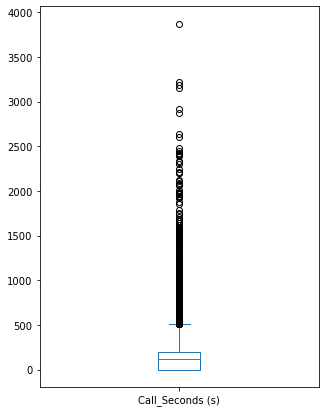

In [148]:
# boxplot of call duration 
call_df["Call_Seconds (s)"].plot.box(figsize=[5,7])
plt.show()

- outlier call durations present in the data, beyond ~2500(41min)

In [182]:
# looking outlier values
call_df[call_df["Call_Seconds (s)"]>2500]

,Agent_Name,Agent_ID,Customer_Phone_No,Queue_Time(Secs),Date_&_Time,Time,Time_Bucket,Duration(hh:mm:ss),Call_Seconds (s),Call_Status,Ringing,IVR _Duration
29369,Executives 10,1000010.0,98797XXXXX,38,2022-01-07,12.0,12_13,0:43:29,2609.0,answered,YES,0:00:22
30191,Executives 63,1000063.0,98760XXXXX,6,2022-01-07,13.0,13_14,0:48:33,2913.0,answered,YES,0:00:15
49457,Executives 10,1000010.0,79084XXXXX,4,2022-01-11,17.0,17_18,1:04:32,3872.0,answered,YES,0:00:24
49844,Executives 43,1000043.0,98961XXXXX,13,2022-01-11,18.0,18_19,0:52:29,3149.0,answered,YES,0:00:14
51284,Executives 3,1000003.0,99046XXXXX,95,2022-01-12,10.0,10_11,0:47:48,2868.0,answered,YES,0:00:13
52597,Executives 5,1000005.0,98800XXXXX,24,2022-01-12,13.0,13_14,0:53:05,3185.0,answered,YES,0:00:13
91887,Executives 39,1000039.0,97648XXXXX,108,2022-01-17,18.0,18_19,0:53:39,3219.0,answered,YES,0:00:24
117046,Executives 12,1000012.0,73888XXXXX,26,2022-01-23,16.0,16_17,0:44:02,2642.0,answered,YES,0:00:16


In [186]:
x1 = call_df[call_df["Call_Seconds (s)"]>2500]
x2 = call_df[call_df["Call_Seconds (s)"]<2500]

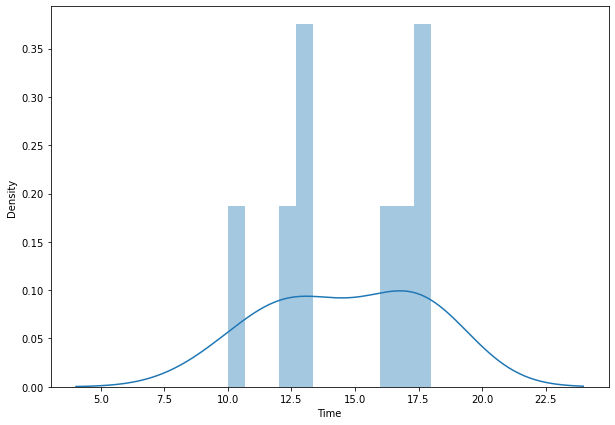

In [187]:
plt.figure(figsize=[10,7])
sns.distplot(x1["Time"],bins=12)
plt.show()

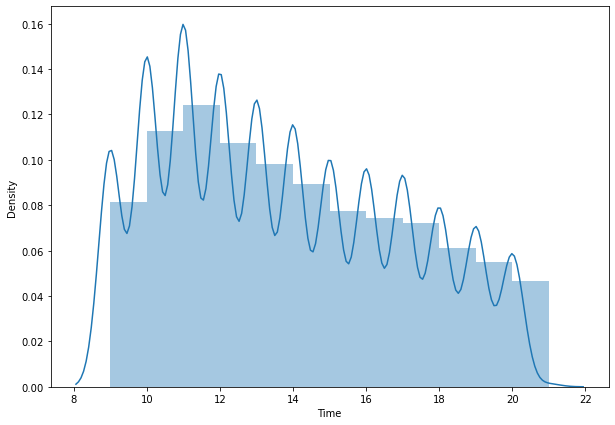

In [188]:
plt.figure(figsize=[10,7])
sns.distplot(x2["Time"],bins=12)
plt.show()

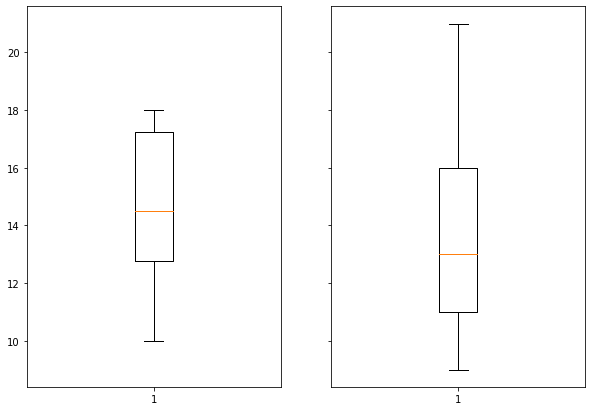

In [198]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True,figsize=[10,7])
ax1.boxplot(x1["Time"])

ax2.boxplot(x2["Time"])
plt.show()

- leaving outliers as it is for the moment moving further analysis

# 3. STANDARDISING AND FIXING INVALID VALUES

In [199]:
# overview of data
call_df.head()

,Agent_Name,Agent_ID,Customer_Phone_No,Queue_Time(Secs),Date_&_Time,Time,Time_Bucket,Duration(hh:mm:ss),Call_Seconds (s),Call_Status,Ringing,IVR _Duration
0,Executives 42,1000042.0,98502XXXXX,2,2022-01-01,9.0,9_10,0:01:36,96.0,answered,YES,0:00:16
1,Executives 4,1000004.0,80595XXXXX,0,2022-01-01,9.0,9_10,0:02:20,140.0,answered,YES,0:00:26
2,Executives 65,1000065.0,70202XXXXX,0,2022-01-01,9.0,9_10,0:01:25,85.0,answered,YES,0:00:16
3,Executives 55,1000055.0,96104XXXXX,1,2022-01-01,9.0,9_10,0:01:31,91.0,answered,YES,0:00:25
4,Executives 21,1000021.0,82001XXXXX,0,2022-01-01,9.0,9_10,0:02:45,165.0,answered,YES,0:00:23


In [207]:
# looking values of Agent_Name
call_df["Agent_Name"].sort_values().unique()

array(['Executives 1', 'Executives 10', 'Executives 11', 'Executives 12',
       'Executives 13', 'Executives 14', 'Executives 15', 'Executives 16',
       'Executives 17', 'Executives 18', 'Executives 19', 'Executives 2',
       'Executives 20', 'Executives 21', 'Executives 22', 'Executives 23',
       'Executives 24', 'Executives 25', 'Executives 26', 'Executives 27',
       'Executives 28', 'Executives 29', 'Executives 3', 'Executives 30',
       'Executives 31', 'Executives 32', 'Executives 33', 'Executives 34',
       'Executives 35', 'Executives 36', 'Executives 37', 'Executives 38',
       'Executives 39', 'Executives 4', 'Executives 40', 'Executives 41',
       'Executives 42', 'Executives 43', 'Executives 44', 'Executives 45',
       'Executives 46', 'Executives 47', 'Executives 48', 'Executives 49',
       'Executives 5', 'Executives 50', 'Executives 51', 'Executives 52',
       'Executives 53', 'Executives 54', 'Executives 55', 'Executives 56',
       'Executives 57', 'Execu

- total **65** Executives are present 

In [209]:
# looking values of time bucket
call_df["Time_Bucket"].unique()

array(['9_10', '10_11', '11_12', '12_13', '13_14', '14_15', '15_16',
       '16_17', '17_18', '18_19', '19_20', '20_21'], dtype=object)

- all values are ok

In [212]:
# looking call status values
call_df["Call_Status"].value_counts()

answered    82452
abandon     34403
transfer     1133
Name: Call_Status, dtype: int64

In [213]:
call_df["Ringing"].value_counts()

YES    117988
Name: Ringing, dtype: int64

- all values of ringing column is "yes"

### Dropping duplicate rows

In [214]:
# looking duplicate rows
call_df.duplicated().sum()

941

In [216]:
# drop
call_df = call_df.drop_duplicates()
call_df.shape

(117047, 12)

- droped all 941 duplicate rows
- final cleaned data have 
  - **rows**: 117047
  - **columns**: 12